# A window into SHAP and LIME on real world datasets

This is a tutorial describing some of the challenges one may face when utilising popular model explaination methods [LIME]() and [SHAP]() on real world datasets


### What makes real world data difficult to model?

When we venture towards data in the real world, we often track large amounts of data with several features that go along with it. There are two main properties that make this data difficult to deal with:

1. Non-Linearity: The data and behavior we track are often non-linear which in turn do not have mathematical properties thatm ake them easy to use.
2. Features are highly correlated, which in turn could confound predictions


As a result of both of these, one might want to use a model which captures non-linearity alongside some degree of dimensionality reduction to be use a Machine Learning model capable of capturing these non-linear relationships on these datasets.

### But what is the downside of this?

Non Linear Models are not interpretable, at least not innately, thats where LIME and SHAP comes in. LIME and SHAP are both post-hoc methods to explain decisions made by Machine Learning models. LIME focuses on explanations within a small subset of the data and SHAP offers an explanation of the whole dataset. These methods have been in frequent use to explain decisions made by Machine Learning models in recent history.

### Are these methods However, Free Lunches? 

Much like everything in statistical Machine learning, no. There are trade-offs these methods have when applied to real-world data. This workshops explores some of the many challenges on may encounter when utilising LIME and SHAP on real world datasets

## SHAP

### What is SHAP?
Quoting the authors of this approach, SHAP is a game theoretic approach which touts to explain the output provided by any machine learning model. The original paper can be accessed [here](). But on a high level the <b>SHAP</b> values are based on the Shapely values of different features, i.e the average contribution a feature has made to a prediction by estimating the change made by each feature when a feature is added/removed

### What does SHAP rely on?

1. The features that are selected from the data; they of course play a large role what the explanation will constitute. 
2. What data instances are sampled when estimating the SHAP values. 

Let's examine Shapley on an existing dataset


### Imports

In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import shap
import time
import pandas as pd
from sklearn.metrics import accuracy_score,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import QuantileTransformer,MinMaxScaler
import matplotlib
import seaborn as sns
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


c:\TA Work\TutorialAI4Over\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Helper Functions/Objects



In [55]:
label_mapping = {0 : 'No Disease',1: 'Mild Disease', 2: 'Moderate Disease', 3:'Serious Disease', 4: 'Critical Condition'}
def generate_outliers(df,num_cols,cat_cols, num_outliers=10, seed=None):
    outliers = pd.DataFrame(columns=df.columns)
    print(df.columns)
    for _ in range(num_outliers):
        rows= {}
        for col_name in num_cols:
            mean = df[col_name].mean()
            std = df[col_name].std()
            outlier_value = mean + np.random.choice([-1, 1]) *2 * std
            rows[col_name] = np.abs(outlier_value)
        
        for col_name in cat_cols:
            unique_values = df[col_name].unique()
            rows[col_name] = np.random.choice(unique_values)
        outliers.loc[len(outliers)] = rows
    
    return outliers

For this tutorial I decided to use the UCI Heart disease predictor dataset

In [49]:
df = pd.read_csv('heart_disease_uci_processed.csv')
numerical_features = df.drop(columns= ['thal', 'slope', 'restecg', 'cp', 'sex','num'])

We don't really have the time for a full scale EDA, however Let's first examine how correlated different features are in this dataset. 

Since this is a popular machine learning dataset we can expect the dataset features to not be that well correlated. 

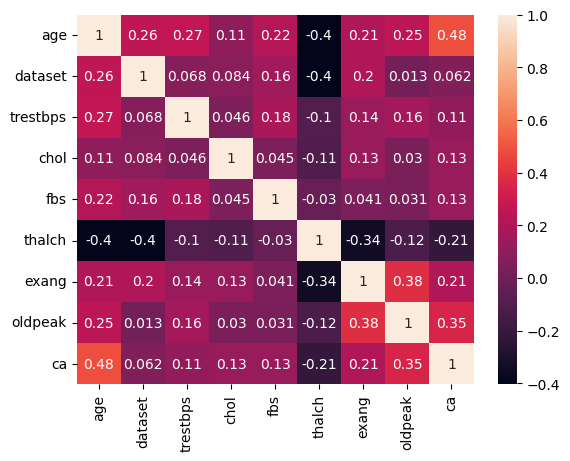

In [50]:
corr = numerical_features.corr()
ax = sns.heatmap(corr,annot = True)

As we can see from the Heatmap, some of the features remain correlated with others, let's examine if this in turn affects how our different explainers 

In particular, we can see that "age" is moderately correlated with the 'ca' feature, alongside the exang and oldpeak feature. Let's see what role this might play further on.

Its also interesting to note moderate negative correlation between age and thalch as well as thalch and exang, lets also keep note of this as we go further down. 


Let's view the explanations made by a classifier and initialise the SHAP explainer. For this, I've taken care of the pre-processing steps you'd follow beforehand and provided the processed version. You can have a look as to what processing was done in the 'dataset-pre-processing.ipyb' notebook


In [84]:
df_processed = pd.read_csv('heart_disease_uci_processed.csv')
features = df_processed.drop(['num','dataset'],axis=1)
target = df_processed['num']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=7215)



In [85]:

pipeline = Pipeline([
    ('scaler', QuantileTransformer(output_distribution='normal')),
    ('classifier', RandomForestClassifier(random_state=62,class_weight='balanced_subsample'))
])
param_grid = {
    'classifier__n_estimators': [50, 100, 200, 300],
    'classifier__max_depth': [None, 5, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=8,  
    scoring='accuracy',  
    n_jobs=-1,  
    verbose=2
)
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Fitting 8 folds for each of 180 candidates, totalling 1440 fits


c:\TA Work\TutorialAI4Over\.venv\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\TA Work\TutorialAI4Over\.venv\lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (649). n_quantiles is set to n_samples.
  warnings.warn(


Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 300}
Best Cross-Validation Score: 0.647169527250828


In [86]:
print(classification_report(y_test,grid_search.best_estimator_.predict(X_test),zero_division=0.0,))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86        73
           1       0.64      0.59      0.61        51
           2       0.46      0.29      0.35        21
           3       0.33      0.56      0.42        16
           4       0.00      0.00      0.00         2

    accuracy                           0.66       163
   macro avg       0.46      0.46      0.45       163
weighted avg       0.67      0.66      0.66       163



From what we can note in the performance on this relatively difficult dataset, the precision is higher than the recall for most classes and alongside that the rarest class 

In [33]:
tree_model = grid_search.best_estimator_[1]
tree_explainer = shap.TreeExplainer(tree_model,data=X_train[:250]) # I used tree instead of Kernel since its just more efficient


Now let's have a look at the SHAP values.

There are several components here that one can consider in the case of a classification task. The SHAP value is typically weighed against a "Baseline" score, i.e a score that a model should predict for the underlying data.
In the case of a multi-class classification task, this is decided based on the distrubtion of the data provided in the TreeExplainer. This in turns changes the way the explanation looks

In [16]:
all_preds = tree_model.predict(X_test)
index = 15
instance = X_test.iloc[index,:]

print(instance)
print(f'Instance label: {label_mapping[y_test.iloc[index]]}')
print(f'Model Prediction: { label_mapping[all_preds[index]]} ')
# Initialise the SHAP explainer
shap_values = tree_explainer.shap_values(instance)


age          62.0
sex           1.0
cp            0.0
trestbps    152.0
chol        153.0
fbs           0.0
restecg       2.0
thalch       97.0
exang         1.0
oldpeak       1.6
slope         2.0
ca            2.0
thal          2.0
Name: 539, dtype: float64
Instance label: Moderate Disease
Model Prediction: Serious Disease 


c:\TA Work\TutorialAI4Over\.venv\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Let's do a small sanity check and see whether our SHAP explainer is indeed correct

In [27]:
class_index = all_preds[index] # Change it here to see other predictions
class_index = 4 # Change here to see the effect predictions could have on other datasets

In [28]:
shap_values = tree_explainer.shap_values(instance)
print("SHAP values for instance:", shap_values[:,class_index].round(5))
print("Sum of SHAP values:", shap_values[:,class_index].sum().round(5))
print("Expected value:", tree_explainer.expected_value[class_index].round(5))
print("Sum of SHAP values and expected value:", (tree_explainer.expected_value[class_index] + shap_values[class_index].sum()).round(5))

SHAP values for instance: [ 0.000e+00  3.140e-03 -7.300e-04  0.000e+00  0.000e+00 -5.300e-04
 -8.000e-05  0.000e+00  1.246e-02  3.090e-03  0.000e+00  3.100e-03
  0.000e+00]
Sum of SHAP values: 0.02045
Expected value: 0.09225
Sum of SHAP values and expected value: 0.09225


Now let's visualise a Force Plot with this model

In [29]:
shap.initjs()

shap.force_plot(tree_explainer.expected_value[class_index], shap_values[:,class_index], instance)

Lets now make a summary over the whole dataset

#### Violin Plots

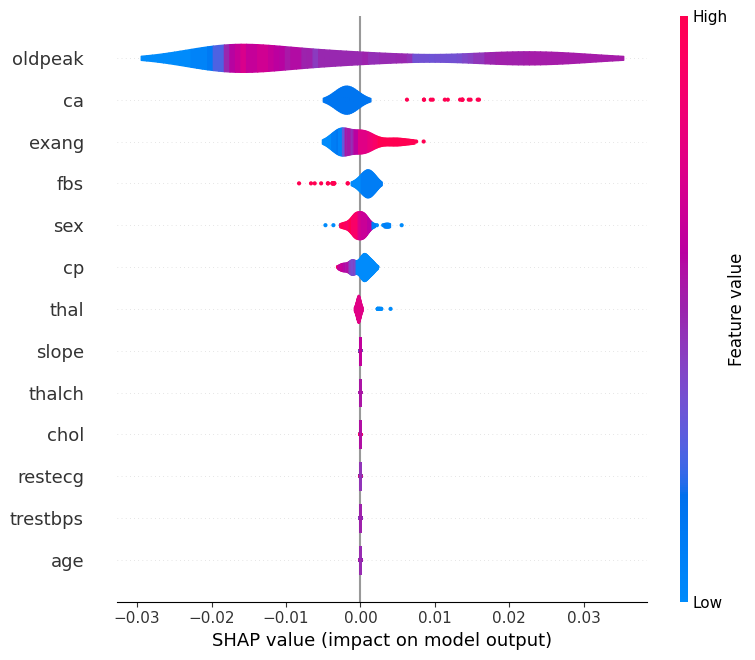

In [36]:
class_index = 2
test_shap_values = tree_explainer.shap_values(X_test)
shap.summary_plot(test_shap_values[:,:,class_index], X_test, plot_type="violin")




#### HeatMap

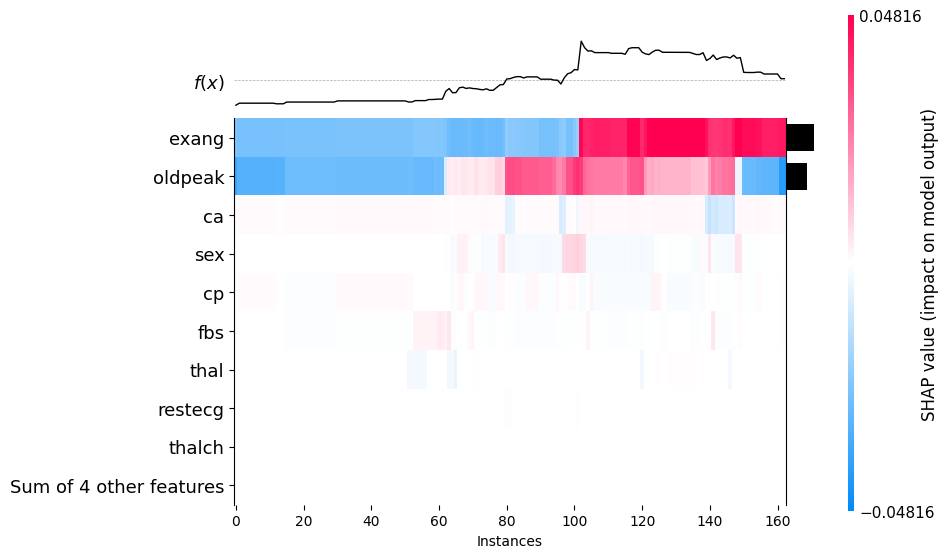

<Axes: xlabel='Instances'>

In [37]:
test_shap_values = tree_explainer(X_test)
shap.plots.heatmap(test_shap_values[:,:,class_index])

#### Dependence Plots

We can also examine the dependency plots between different variables, that is how the SHAP values interact between different variables. 
This gives us insight into dependency between variables. An interesting question we could raise here is how the SHAP values interact with correlated features

In [44]:
shap_values = tree_explainer.shap_values(X_test)

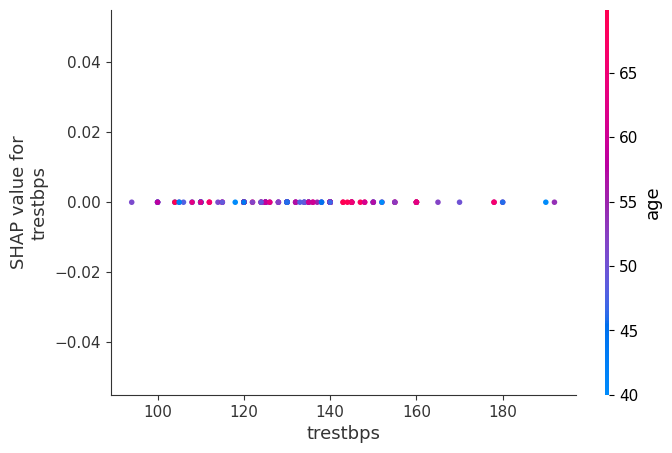

In [52]:
shap.dependence_plot("trestbps", shap_values[:,:,2], X_test)


So these plots give us some insights about the data. It appears as if Old-peak plays a large role in prediction. It's also really clear that its quite important that the whole distribution is required to ensure the explanations do indeed have some fidelity.


Let's try these explanations on another model, with the popular XGBoost  and now use the Kernel Explainer

In [54]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(class_weight = 'balanced' ,y=y_train)

In [55]:
pipeline = Pipeline([
    ('classifier', xgb.XGBClassifier(use_label_encoder=False,objective='multi:softmax', eval_metric='merror', random_state=12,sample_weights=sample_weights))
])
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [ 3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
}
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5 ,  
    scoring='accuracy',  
    n_jobs=-1, 
    verbose=2
)
grid_search.fit(X_train,y_train)
print("Best Cross-Validation Score:", grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Cross-Validation Score: 0.648741800834824


c:\TA Work\TutorialAI4Over\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:00:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "sample_weights", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [56]:
print(classification_report(y_test,grid_search.best_estimator_[0].predict(X_test),zero_division=0.0))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84        73
           1       0.62      0.65      0.63        51
           2       0.33      0.19      0.24        21
           3       0.40      0.62      0.49        16
           4       0.00      0.00      0.00         2

    accuracy                           0.66       163
   macro avg       0.44      0.46      0.44       163
weighted avg       0.65      0.66      0.65       163



now, lets look at the explainer for this data-point

In [95]:
grad_explainer = shap.TreeExplainer(grid_search.best_estimator_[0],data=X_train)

In [83]:
shap_values = grad_explainer.shap_values(X_test)

In [96]:
all_preds = grid_search.best_estimator_[0].predict(X_test)
index = 12
instance = X_test.iloc[index,:]

print(instance)
print(f'Instance label: {label_mapping[y_test.iloc[index]]}')
print(f'Model Prediction: { label_mapping[all_preds[index]]} ')

age          55.0
sex           1.0
cp            1.0
trestbps    140.0
chol        196.0
fbs           0.0
restecg       1.0
thalch      150.0
exang         0.0
oldpeak       0.0
slope         2.0
ca            0.0
thal          2.0
Name: 452, dtype: float64
Instance label: No Disease
Model Prediction: No Disease 


In [97]:
class_index = all_preds[index] # Change it here to see other predictions
class_index = 3

An important point here to note, these values are the Log Odds, so negative values here is expected, the prediction probabilites can be extracted by applying the formula f(p) = exp(p)/1+exp(p)

In [98]:
grad_explainer.expected_value

array([ 0.79414419,  0.84075247, -0.32333259, -0.28754577, -1.21805897])

In [86]:
shap_values = grad_explainer.shap_values(instance)
print("SHAP values for instance:", shap_values[:,class_index].round(5))
print("Sum of SHAP values:", shap_values[:,class_index].sum().round(5))
print("Expected value:", grad_explainer.expected_value[class_index].round(5))
print("Sum of SHAP values and expected value:", (grad_explainer.expected_value[class_index] + shap_values[class_index].sum()).round(5))

SHAP values for instance: [-0.02421  0.01813 -0.05771  0.00416 -0.09251 -0.00086 -0.02115 -0.28978
 -0.141   -0.38176  0.      -0.39388  0.06386]
Sum of SHAP values: -1.31672
Expected value: -0.28755
Sum of SHAP values and expected value: -0.37646


In [100]:
shap.force_plot(grad_explainer.expected_value[class_index], shap_values[:,class_index],X_test.iloc[index,:],link='logit') # We made a small change here to see the probability instead of the raw logit value 

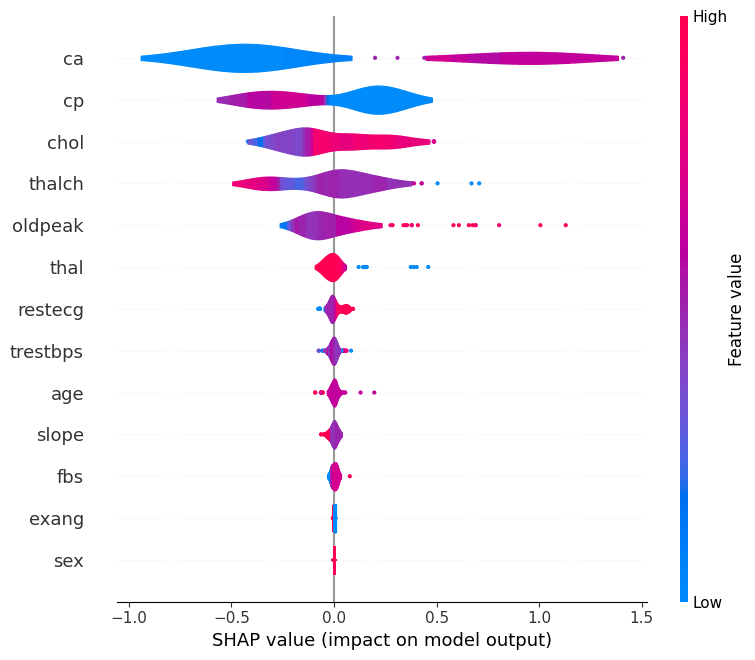

In [88]:
test_shap_values = grad_explainer.shap_values(X_test)
shap.summary_plot(test_shap_values[:,:,2], X_test.iloc[:,:],plot_type = 'violin')

Interestingly, despite similar performance, we have vastly different importances when we look at this model's features, somethign qu 

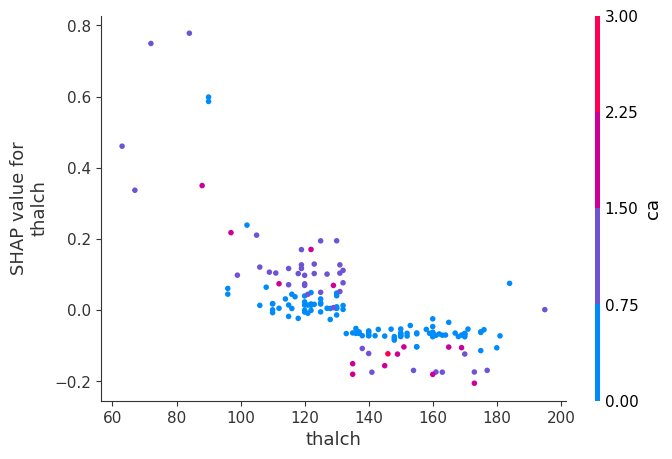

In [103]:
shap.dependence_plot("thalch", test_shap_values[:,:,4], X_test)


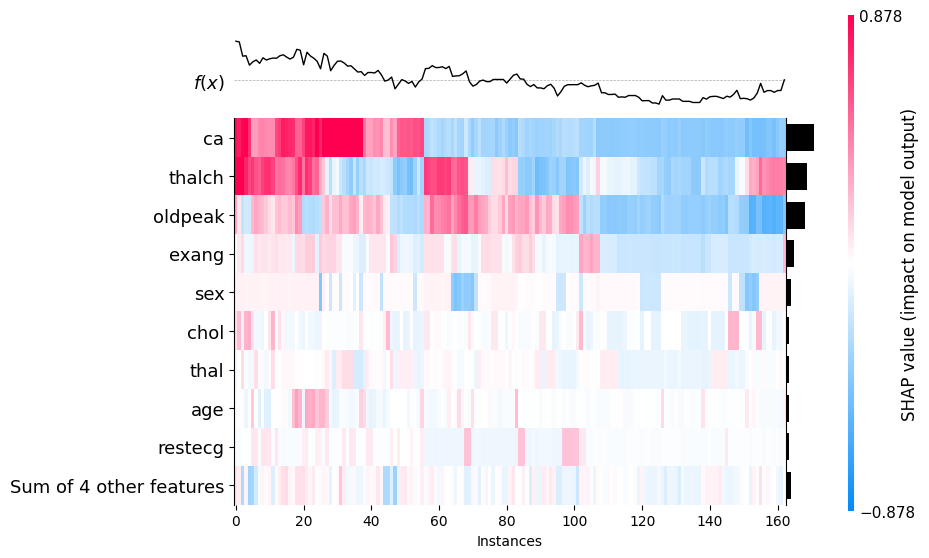

<Axes: xlabel='Instances'>

In [105]:
test_shap_values = grad_explainer(X_test)
shap.plots.heatmap(test_shap_values[:,:,class_index])


#### Outliers

From the pre-processing code, I've saved a few of the outliers from the dataset, outliers naturally are a big part of dealing with the real-world. How do outliers affect our SHAP explanations?


In [159]:
num =  ['age','trestbps', 'chol', 'thalch', 'oldpeak']
categ_cols = ['sex','cp','fbs', 'restecg', 'exang', 'slope', 'thal', 'ca','age']

outliers = generate_outliers(df_processed,num,categ_cols,10)
outliers = outliers.drop(['dataset','num'],axis=1)


Index(['age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')


In [160]:
outliers

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
0,39,0,3,95.992290,307.859801,1.0,0.0,187.734398,1.0,1.320226,1.0,1.0,0.0
1,53,0,0,95.992290,307.859801,0.0,1.0,85.696637,0.0,1.320226,1.0,1.0,2.0
2,32,0,1,95.992290,307.859801,1.0,1.0,85.696637,1.0,2.973182,1.0,1.0,2.0
3,65,1,0,168.261404,163.866800,1.0,0.0,85.696637,1.0,1.320226,1.0,1.0,0.0
4,65,0,1,95.992290,163.866800,0.0,1.0,187.734398,0.0,1.320226,2.0,3.0,2.0
5,40,0,2,168.261404,163.866800,0.0,2.0,187.734398,1.0,2.973182,2.0,1.0,1.0
6,54,1,3,95.992290,163.866800,0.0,2.0,85.696637,1.0,2.973182,0.0,2.0,2.0
7,58,0,3,168.261404,163.866800,1.0,2.0,187.734398,1.0,2.973182,1.0,3.0,0.0
8,73,1,0,95.992290,307.859801,0.0,0.0,85.696637,0.0,2.973182,1.0,1.0,2.0
9,57,1,3,168.261404,163.866800,1.0,1.0,85.696637,1.0,1.320226,0.0,2.0,2.0


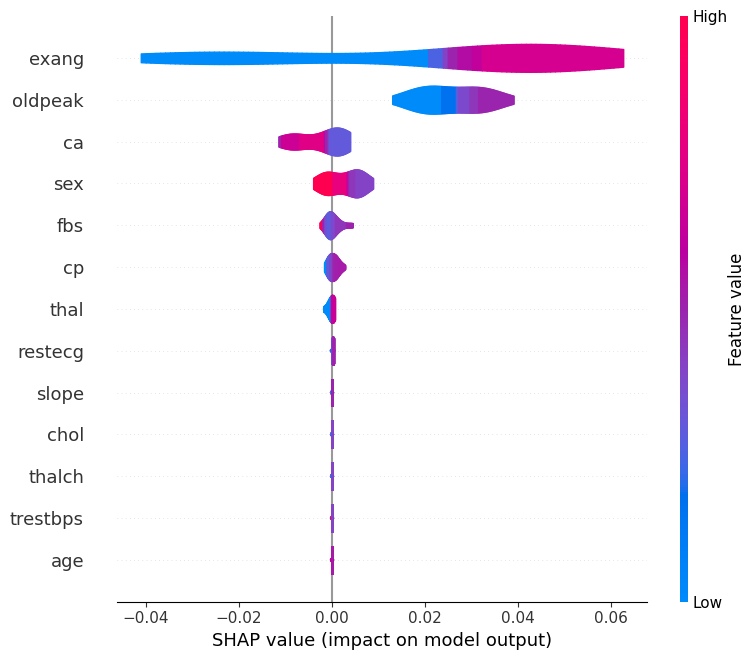

In [163]:
outlier_shap_values = tree_explainer.shap_values(outliers)
shap.summary_plot(outlier_shap_values[:,:,3], outliers,plot_type = 'violin')

#### Can we feature engineer with this? 

Since we see the certain features are more emphasied than others, especially with the heatmap, what happens to our classifiers when we cut out features they were not using, would that improve or harm the accuracy of our models?

In [5]:
columns_to_include = ['ca','oldpeak','cp','fbs','chol','age','exang']
reduced_features = df_processed[columns_to_include]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=7215)


NameError: name 'df_processed' is not defined

In [168]:
pipeline = Pipeline([
    ('scaler', QuantileTransformer(output_distribution='normal')),
    ('classifier', RandomForestClassifier(random_state=62,class_weight='balanced_subsample'))
])
param_grid = {
    'classifier__n_estimators': [50,100, 200, 300],
    'classifier__max_depth': [None,3,5, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=8,  
    scoring='accuracy',  
    n_jobs=-1,  
    verbose=2
)
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Fitting 8 folds for each of 216 candidates, totalling 1728 fits


c:\TA Work\TutorialAI4Over\.venv\lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (649). n_quantiles is set to n_samples.
  warnings.warn(


Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 300}
Best Cross-Validation Score: 0.647169527250828


In [169]:
print(classification_report(y_test,grid_search.best_estimator_.predict(X_test),zero_division=0.0,))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86        73
           1       0.64      0.59      0.61        51
           2       0.46      0.29      0.35        21
           3       0.33      0.56      0.42        16
           4       0.00      0.00      0.00         2

    accuracy                           0.66       163
   macro avg       0.46      0.46      0.45       163
weighted avg       0.67      0.66      0.66       163



From what we can see, the performance changes landed a minimal impact on the model's performance, however this may also vary between models 

## Loan Approval Dataset

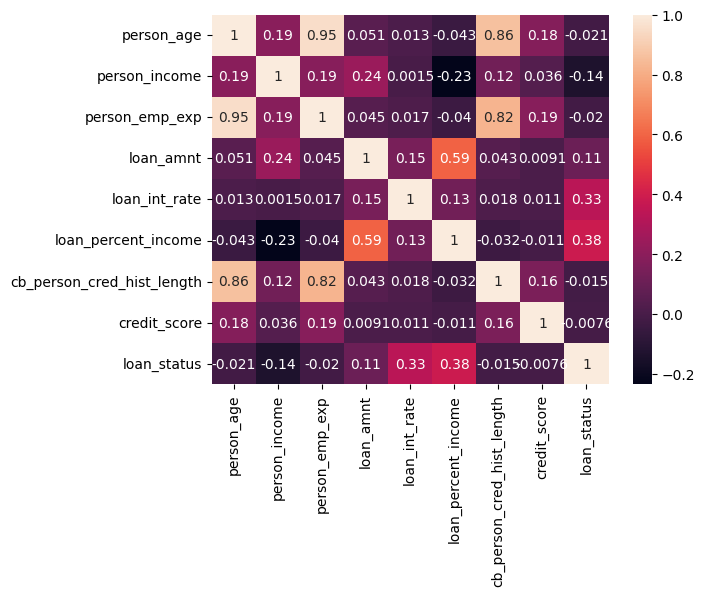

In [6]:
df = pd.read_csv('loan_data_processed.csv')
numerical_features = df.drop(columns= ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file'])
num_columns = [
    'person_income', 
    'loan_amnt', 
    'loan_int_rate', 
    'loan_percent_income', 
    'cb_person_cred_hist_length', 
    'credit_score'
]

corr = numerical_features.corr()
ax = sns.heatmap(corr,annot = True)


In [7]:
features = df.drop(['loan_status'],axis=1)
target = df['loan_status']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features[:int(0.2*len(features))], target[:int(0.2*len(features))], test_size=0.20, random_state=7215)


In [9]:

pipeline = Pipeline([
    ('scaler', QuantileTransformer(output_distribution='normal')),
    ('classifier', RandomForestClassifier(random_state=62,class_weight='balanced'))
])
param_grid = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [20, 30],
    'classifier__min_samples_split': [5, 10],
    'classifier__min_samples_leaf': [2, 4],
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=8,  
    scoring='accuracy',  
    n_jobs=-1,  
    verbose=2
)
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Fitting 8 folds for each of 8 candidates, totalling 64 fits
Best Parameters: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Best Cross-Validation Score: 0.9091666666666667


In [10]:
tree_model = grid_search.best_estimator_[1]
tree_explainer = shap.TreeExplainer(tree_model,data = X_test) 

In [11]:
print(classification_report(y_test,grid_search.best_estimator_.predict(X_test),zero_division=0.0,))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1349
           1       0.85      0.80      0.83       451

    accuracy                           0.92      1800
   macro avg       0.89      0.88      0.89      1800
weighted avg       0.91      0.92      0.91      1800



In [12]:
label_mapping = {0:'Not approved', 1:'Approved'}

In [13]:
all_preds = tree_model.predict(X_test)
index = 155
instance = X_test.iloc[index,:]

print(instance)
print(f'Instance label: {label_mapping[y_test.iloc[index]]}')
print(f'Model Prediction: { label_mapping[all_preds[index]]} ')
# Initialise the SHAP explainer
shap_values = tree_explainer.shap_values(instance)

person_age                           22.00
person_gender                         0.00
person_education                      0.00
person_income                     24993.00
person_emp_exp                        1.00
person_home_ownership                 0.00
loan_amnt                         16600.00
loan_intent                           4.00
loan_int_rate                         9.76
loan_percent_income                   0.66
cb_person_cred_hist_length            3.00
credit_score                        634.00
previous_loan_defaults_on_file        1.00
Name: 640, dtype: float64
Instance label: Not approved
Model Prediction: Not approved 


c:\TA Work\TutorialAI4Over\.venv\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [14]:
class_index = all_preds[index] # Change it here to see te contributions to other classes
shap_values = tree_explainer.shap_values(instance)
print("SHAP values for instance:", shap_values[:,class_index].round(5))
print("Sum of SHAP values:", shap_values[:,class_index].sum().round(5))
print("Expected value:", tree_explainer.expected_value[class_index].round(5))
print("Sum of SHAP values and expected value:", (tree_explainer.expected_value[class_index] + shap_values[class_index].sum()).round(5))

SHAP values for instance: [ 0.000e+00  7.430e-03  1.830e-03  0.000e+00  5.300e-03  4.235e-02
  0.000e+00  1.300e-04  0.000e+00 -1.994e-02  1.420e-03  0.000e+00
  1.598e-01]
Sum of SHAP values: 0.19832
Expected value: 0.75398
Sum of SHAP values and expected value: 0.75398


In [15]:
shap.initjs()

shap.force_plot(tree_explainer.expected_value[class_index], shap_values[:,class_index], instance)

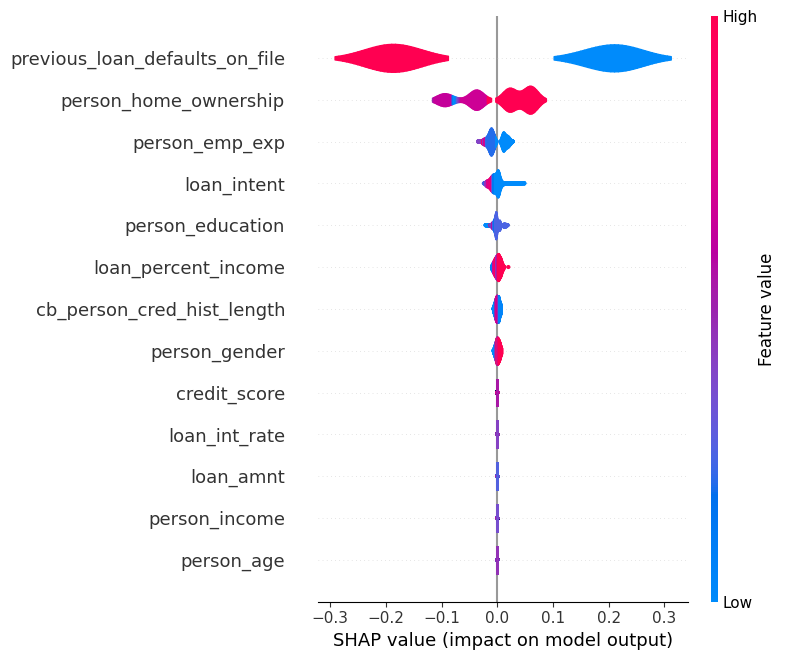

In [16]:
class_index = 1
test_shap_values = tree_explainer.shap_values(X_test)
shap.summary_plot(test_shap_values[:,:,class_index], X_test, plot_type="violin")

#### HeatMaps

 96%|=================== | 3467/3600 [00:11<00:00]       

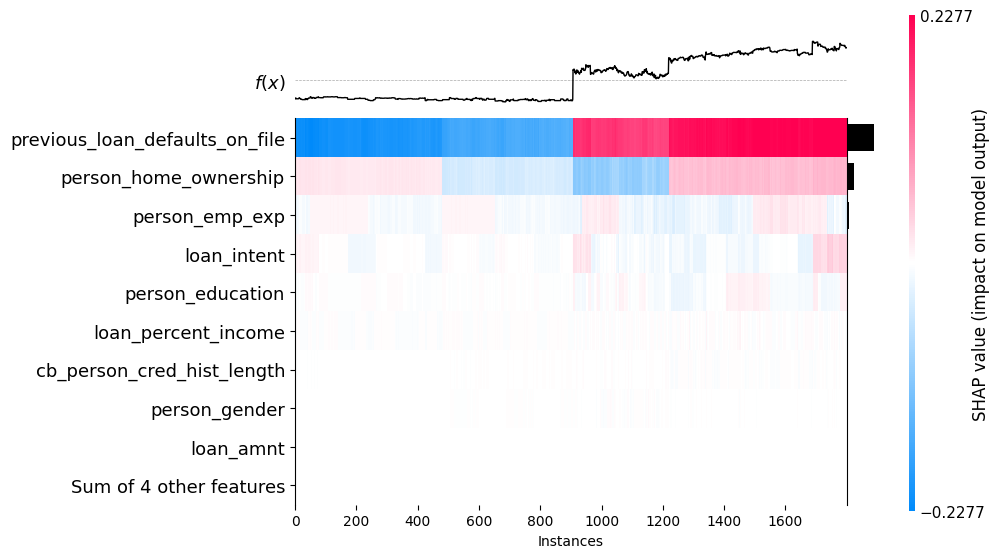

<Axes: xlabel='Instances'>

In [17]:
test_shap_values = tree_explainer(X_test)
shap.plots.heatmap(test_shap_values[:,:,class_index])

# LIME

We visualize the process taken by LIME below: 


![alt text](lime.gif "Title")

In [62]:
list(label_mapping.values())

['No Disease',
 'Mild Disease',
 'Moderate Disease',
 'Serious Disease',
 'Critical Condition']

In [109]:
import lime
from lime import lime_tabular
explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(X_train),feature_names=X_train.columns,class_names=list(label_mapping.values()),
    mode='classification',kernel_width = 20)
pred = grid_search.best_estimator_.predict(X_test)

In [110]:
test_index = 35
exp = explainer.explain_instance(
    data_row=X_test.iloc[test_index],
    predict_fn=grid_search.best_estimator_.predict_proba,distance_metric='manhattan')
print('Model prediction: ', label_mapping[pred[test_index]])
print('True label: ', label_mapping[y_test.iloc[test_index]])
# check also LIME linear model predictions
print('LIME prediction: ', label_mapping[pred[test_index]])

Model prediction:  No Disease
True label:  No Disease
LIME prediction:  No Disease


c:\TA Work\TutorialAI4Over\.venv\lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\TA Work\TutorialAI4Over\.venv\lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\TA Work\TutorialAI4Over\.venv\lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acce

In [111]:
exp.show_in_notebook(show_table=True)